In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")
import torch
import torch_geometric
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from Scripts import train_metric_learning, run_metric_learning_inference, train_gnn, run_gnn_inference, build_track_candidates, evaluate_candidates
from Scripts.utils.convenience_utils import get_example_data, plot_true_graph, get_training_metrics, plot_training_metrics, plot_neighbor_performance, plot_predicted_graph, plot_track_lengths, plot_edge_performance, plot_graph_sizes
import yaml

CONFIG = 'pipeline_config.yaml'


/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

Loading BokehJS ...

In [4]:
data_quirk = torch.load("datasets/feature_store/QuirkTracking_sample/1000")
#data = torch.load("../TrackML_Quickstart/datasets/quickstart_example_1GeV/21000")
#data = pd.read_csv("datasets/Quirk/event000001014-hits.csv")
data_quirk

Data(x=[526, 3], pid=[526], event_file='datasets/Quirk/event000001000', hid=[526], pt=[526], modulewise_true_edges=[2, 459], layerwise_true_edges=[2, 459])

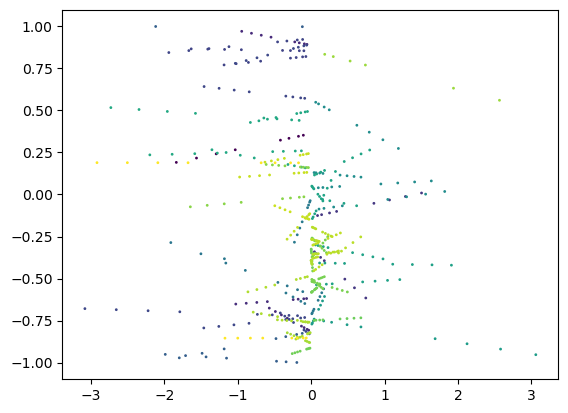

In [7]:
#plt.scatter(data.x[:,0], data.x[:,1], c=data.pid, s=1)
plt.scatter(data_quirk.x[:,2], data_quirk.x[:,1], c=data_quirk.pid, s=1)

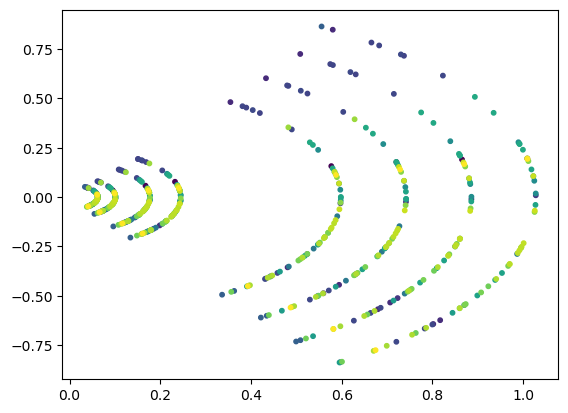

In [ ]:
#r, phi, z = data.x[:, 0], data.x[:, 1], data.x[:, 2]
#x,y = r * torch.cos(phi), r * torch.sin(phi)
#plt.scatter(x, y, s=10, c=data.pid)

r1, phi1, z1 = data_quirk.x[:, 0], data_quirk.x[:, 1], data_quirk.x[:, 2]
x1,y1 = r1 * torch.cos(phi1), r1 * torch.sin(phi1)
plt.scatter(x1, y1, s=10, c=data_quirk.pid)

# 0. Download Data

### Pipeline configurations

The configurations for the entire pipeline are defined under pipeline_config.yml. 

In [8]:
import yaml
with open(CONFIG, 'r') as f:
    configs = yaml.load(f, Loader=yaml.FullLoader)

# 1. Train Metric Learning

## What it does
Broadly speaking, the first stage of our pipeline is embedding the space points on to graphs, in a way that is efficient, i.e. we miss as few points on a graph as possible. We train a MLP to transform the input feature vector of each space point $\mathbf{u}_i$ into an N-dimensional latent space $\mathbf{v}_i$. The graph is then constructed by connecting the space points whose Euclidean distance between the latent space points $$d_{ij} = \left| \mathbf{v}_i - \mathbf{v}_j \right| < r_{embedding}$$

## Training data
Let us take a look at the data before training. In this example pipeline, we have preprocessed the TrackML data into a more convenient form. We calculated directional information and summary statistics from the charge deposited in each spacepoints, and append them to its cyclidrical coordinates. Let us load an example data file and inspect the content.

In [16]:
example_data_df, example_data_pyg = get_example_data(configs) #get the example event---event 0   output: example_hit_df (dataframe), training_example
example_data_df.head()  #default 5 lines. 

,0,1,2
0,0.062,0.644834,0.0492
1,0.101,0.641032,0.0800
2,0.177,0.633742,0.1400
3,0.245,0.627006,0.1940
4,0.598,0.592054,0.4756


In [17]:
example_data_pyg

Data(x=[1140, 3], pid=[1140], event_file='datasets/feature_store/QuirkTracking_sample/1056', hid=[1140], pt=[1140], modulewise_true_edges=[2, 994], layerwise_true_edges=[2, 995], signal_true_edges=[2, 994])

In [22]:
plot_true_graph(example_data_pyg, num_tracks=250)

## Train metric learning model

Finally we come to model training. By default, we train the MLP for 30 epochs, which takes approximately 15 minutes on an NVidia V100. Feel free to adjust the epoch number in pipeline_config.yml

In [29]:
metric_learning_trainer, metric_learning_model = train_metric_learning(CONFIG)

-------------------- Step 1: Running metric learning training --------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:474: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 3.2 M 
---------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.694    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]                            

/eos/user/q/qsha/work/miniconda/envs/exatrkx-gpu/lib/python3.9/site-packages/pytorch_lightning/loops/optimization/optimizer_loop.py:362: LightningDeprecationWarning: The NVIDIA/apex AMP implementation has been deprecated upstream. Consequently, its integration inside PyTorch Lightning has been deprecated in v1.9.0 and will be removed in v2.0.0. The `LayerlessEmbedding.optimizer_step()` hook is overridden, including the `using_native_amp` argument. Removing this argument will avoid this message, you can expect it to return True.
  rank_zero_deprecation(


Epoch 29: 100%|██████████| 79/79 [00:22<00:00,  3.45it/s, loss=0.00696, v_num=2]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 79/79 [00:23<00:00,  3.40it/s, loss=0.00696, v_num=2]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

We can examine how the training went. This is stored in a simple dataframe:

In [30]:
embedding_metrics = get_training_metrics(metric_learning_trainer)
embedding_metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.009723,0.004960,0.988072,0.024080,0.000125
1,1,0.008684,0.004592,0.932172,0.063826,0.000250
2,2,0.008613,0.004377,0.955293,0.103018,0.000375
3,3,0.008326,0.004434,0.978831,0.082528,0.000350
4,4,0.008181,0.004076,0.971981,0.160444,0.000625


In [32]:
plot_training_metrics(embedding_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [54]:
plot_neighbor_performance(metric_learning_model)  #radius = 0.1 comes from config file (r_test = 0.1)  r_min = 0.01

Loading BokehJS ...

Loading BokehJS ...

cuda
Data(x=[863, 3], pid=[863], event_file='datasets/feature_store/QuirkTracking_sample/1035', hid=[863], pt=[863], modulewise_true_edges=[2, 753], layerwise_true_edges=[2, 753], signal_true_edges=[2, 753])


## Plot example truth and predicted graphs

In [81]:
plot_predicted_graph(metric_learning_model)  #default radius is 0,1. use the test_data_0
## ? why only 10 tracks, I try to change to for i, track in enumerate(true_unique[true_lengths >= 10][:100]) but not work.##

Loading BokehJS ...

Loading BokehJS ...

Data(x=[863, 3], pid=[863], event_file='datasets/feature_store/QuirkTracking_sample/1035', hid=[863], pt=[863], modulewise_true_edges=[2, 753], layerwise_true_edges=[2, 753], signal_true_edges=[2, 753])
tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14, 12, 10, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 10, 14, 14, 14, 14, 14, 14, 12, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14,
        14, 14, 14, 14, 14, 14, 14, 14,  8, 12, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 12, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 12, 14, 14, 14, 12, 10, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14], device='cuda:0')
tensor([ 201.,  202.,  223.,  578.,  580.,  601.,  605.,  641.,  642.,  748.,
         768.,  772.,  773.,  778.,  782.,  783.,  801.,  911.,  943.,  973.,
         974.,  979., 1032., 1059., 1063., 1065., 1066., 1067., 1069., 1070.,
        1168., 1170., 1191., 1195., 1199., 1279.,

In [65]:

plot_predicted_graph(metric_learning_model, radius=0.09)

## Track lengths

In [55]:
plot_track_lengths(metric_learning_model)

100%|██████████| 71/71 [00:18<00:00,  3.93it/s]


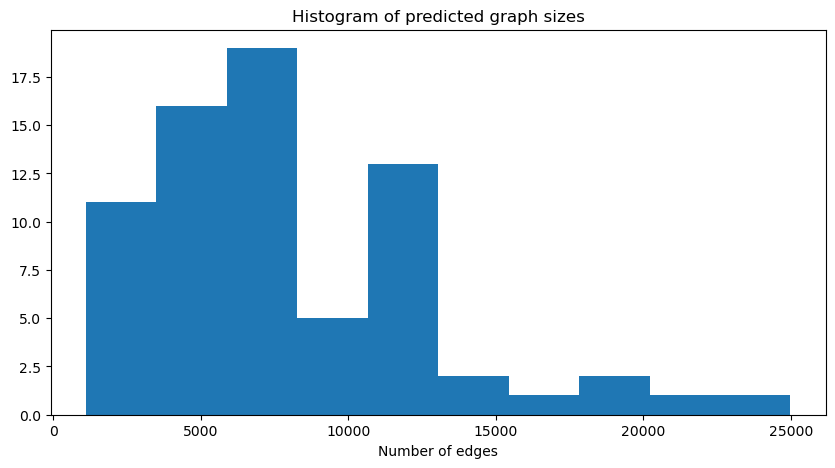

In [ ]:
plot_graph_sizes(metric_learning_model) # number of training sample


# 2. Construct graphs from metric learning inference

This step performs model inference on the entire input datasets (train, validation and test), to obtain input graphs to the graph neural network. Optionally, we also clear the directory.

In [82]:
graph_builder = run_metric_learning_inference(CONFIG)

------------- Step 2: Constructing graphs from metric learning model -------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to build graphs...


100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


In [83]:
graph_builder

# 3. Train graph neural networks

We have a set of graphs constructed. We now train a GNN to classify edges as either "true" (belonging to the same track) or "false" (not belonging to the same track). We train for 30 epochs, which should take around 10 minutes on a V100 GPU. Your mileage may vary.

In [94]:
import warnings
warnings.filterwarnings("ignore")
gnn_trainer, gnn_model = train_gnn(CONFIG)

-------------------------  Step 3: Running GNN training  -------------------------
----------------------------- a) Initialising model -----------------------------
------------------------------ b) Running training ------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.0 K
1 | edge_encoder           | Sequential | 66.4 K
2 | edge_network           | Sequential | 82.8 K
3 | node_network           | Sequential | 82.8 K
4 | output_edge_classifier | Sequential | 83.2 K
------------------------------------------------------
349 K     Trainable params
0         Non-trainable params
349 K     Total params
1.397     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 79/79 [00:09<00:00,  8.07it/s, loss=0.0206, v_num=18]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s, loss=0.0206, v_num=18]
-------------------------------- c) Saving model --------------------------------


## Plot training metrics

In [91]:
gnn_metrics = get_training_metrics(gnn_trainer)
gnn_metrics.head()

,epoch,train_loss,val_loss,eff,pur,current_lr
0,0,0.020539,0.031376,1.0,1.0,0.0002


In [ ]:
plot_training_metrics(gnn_metrics)

## Evaluate model performance on sample test data

Here we evaluate the model performace on one sample test data. We look at how the efficiency and purity change with the embedding radius.

In [88]:
plot_edge_performance(gnn_model)

ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

# Step 4: GNN inference 

In [89]:
run_gnn_inference(CONFIG)

--------------------- Step 4: Scoring graph edges using GNN  ---------------------
---------------------------- a) Loading trained model ----------------------------
----------------------------- b) Running inferencing -----------------------------
Training finished, running inference to filter graphs...
Building train


100%|██████████| 71/71 [00:21<00:00,  3.30it/s]


Building val


100%|██████████| 8/8 [00:00<00:00, 36.71it/s]


Building test


100%|██████████| 8/8 [00:00<00:00, 18.14it/s]


# Step 5: Build track candidates from GNN

In [ ]:
build_track_candidates(CONFIG)

-----------  Step 5: Building track candidates from the scored graph  -----------
---------------------------- a) Loading scored graphs ----------------------------
---------------------------- b) Labelling graph nodes ----------------------------


100%|██████████| 87/87 [00:01<00:00, 68.18it/s]


# Step 6: Evaluate track candidates

We can control the matching style in the pipeline config file. The following all require at least a majority of hits to match in each scheme (i.e. matching fraction = 50%).
A discussion of each matching style and some worked examples can be found in the [Documentation](https://hsf-reco-and-software-triggers.github.io/Tracking-ML-Exa.TrkX/performance/matching_definitions/).

ATLAS style matching is the default.

------------ Step 6: Evaluating the track reconstruction performance ------------
--------------------------- a) Loading labelled graphs ---------------------------


100%|██████████| 87/87 [00:01<00:00, 52.59it/s]


--------------------- b) Calculating the performance metrics ---------------------
Number of reconstructed particles: 87
Number of particles: 8478
Number of matched tracks: 87
Number of tracks: 87
Number of duplicate reconstructed particles: 0
Efficiency: 0.010
Fake rate: 0.000
Duplication rate: 0.000
------------------------------ c) Plotting results ------------------------------


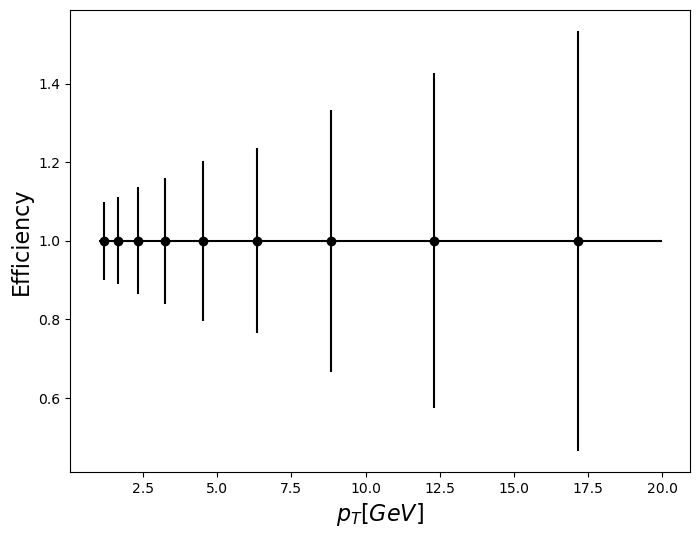

In [ ]:
evaluated_events, reconstructed_particles, particles, matched_tracks, tracks = evaluate_candidates(CONFIG)